# Building a training dataset for drug repositioning in Parkinson disease: a proof-of-concept of the CompDReAM approach

##### Written by: Florion Peni, UCL
##### Supervisor: Prof Edith Chan, UCL
-----
### UMLS API access and license requirements

Running this notebook requires obtaining a **license** and **API key** from the **National Library of Medicine (NLM)** for the **Unified Medical Language System (UMLS) API**. The UMLS REST API requires authentication through a UMLS account. If you do not have an account, you can apply for a license via the [UMLS Terminology Services (UTS) website](https://uts.nlm.nih.gov/).

The UMLS integrates and distributes key terminologies, classification systems, and coding standards, providing essential resources for the development of interoperable biomedical information systems, including electronic health records.

### CUIs and MeSH UID Mapping

In the UMLS, each **Concept Unique Identifier (CUI)** represents a distinct biomedical concept, linking terms and synonyms from various medical vocabularies, such as **MeSH**, **SNOMED CT**, and **ICD**, under a single identifier. This standardisation enhances interoperability across different databases and facilitates the integration of biomedical knowledge.

However, *UMLS may associate a single MeSH Unique Identifier (MeSH UID) with multiple CUIs*. To ensure accurate mapping, **MedGen** reports all valid mappings from UMLS.

To perform **CID-to-MeSH UID mapping**, we utilised the `MedGenIDMappings.txt` file (2025 version), downloaded from the [MedGen FTP site](https://ftp.ncbi.nlm.nih.gov/pub/medgen/). A precomputed CUI-to-MeSH UID mapping file ([`CUI_to_MeSH.csv`](CUI_to_MeSH.csv)) has been made available in the `data` folder and the code for generating it has been commented out in the first cell.

The `fetch_mesh_from_cui(cui)` function first checks [`CUI_to_MeSH.csv`](CUI_to_MeSH.csv). If the CUI exists in the mapping dictionary (`cui_mesh_mapping`), it returns the stored MeSH UID.  If no mapping is found in the file, the code queries the UMLS REST API. It then parses the API response to find a MeSH UID from the `"sourceDescriptor"` field under the `"MSH"` root source. If a valid mapping is found, it updates the dictionary to avoid redundant API requests in the future.

The `fetch_mesh_name(mesh_id)` function ensures that the MeSH UIDs obtained from CUIs are **correctly mapped to their standardised disease names**, allowing for clearer data interpretation and analysis. It directly queries the UMLS REST API by dynamically constructing request URLs.

As a proof of concept, we begin by loading the `DISEASES_Summary_GDA_CURATED_C0030567.tsv` file obtained from **[DisGeNET](!https://disgenet.com)** by querying the term *"Parkinson Disease"* (CUI: C0030567). To analyse a different disease, the variables `file_path`, `API_KEY`, and `CUI` must be updated accordingly before running the programme.

Note that the results shown here were obtained using a DisGeNET **academic license**.<sup>[1]</sup>

<sup>[1]: Academic users have access only to curated data sources, which include: PSYGENET, ORPHANET, CLINGEN, CLINVAR, UNIPROT, and RGD_HUMAN.</sup>

In [1]:
import pandas as pd
import requests
import time
import glob
import os
import re
import cache
import json
import chembl_downloader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from io import StringIO
from chembl_webresource_client.new_client import new_client
from IPython.core.magic import register_cell_magic  # Needed for %%skip Jupyter cell magic

tqdm().pandas()

@register_cell_magic
def skip(line, cell):
    return

#medgen_df = pd.read_csv("data/MedGenIDMappings.txt", sep="|", dtype=str, skiprows=1,
#names=["CUI", "pref_name", "source_id", "source", "unknown"])
#medgen_df = medgen_df.map(lambda x: x.strip() if isinstance(x, str) else x)
#cui_mesh_df = medgen_df[medgen_df["source"].str.strip() == "MeSH"][["CUI", "source_id"]]
#cui_mesh_df = cui_mesh_df.rename(columns={"source_id": "MSH"})
#cui_mesh_df = cui_mesh_df.dropna(subset=["MSH"])
#cui_mesh_df.to_csv("data/CUI_to_MeSH.csv", index=False)

file_path = "DISEASES_Summary_GDA_CURATED_C0030567.tsv"  # Change for your desired file
API_KEY = "7eaf32db-24f3-4d66-b3cc-cc9a1ad56f9a"  # Replace with your actual UMLS API key
API_DELAY = 0.8
CUI = "C0030567"  # Change with CUI corresponding to your .tsv file from DisGeNET
BASE_URL = "https://uts-ws.nlm.nih.gov/rest/content/current/"
cui_mesh_mapping = pd.read_csv("data/CUI_to_MeSH.csv", dtype=str).set_index("CUI")["MSH"].to_dict()

def fetch_mesh_from_cui(cui):
    """Fetches the MeSH ID from the precomputed mapping file or UMLS API."""
    # Checks if CUI exists in precomputed mappings
    if cui in cui_mesh_mapping:
        return cui_mesh_mapping[cui]
    # If not found, queries UMLS API
    cui_url = f"{BASE_URL}CUI/{cui}/atoms?apiKey={API_KEY}"
    response = requests.get(cui_url)
    if response.status_code == 200:
        data = response.json()
        for result in data.get("result", []):
            if result["rootSource"].startswith("MSH") and "sourceDescriptor" in result:
                mesh_id = result["sourceDescriptor"].split("/")[-1]
                # Updates the dictionary with the new mapping to avoid repeated API calls
                cui_mesh_mapping[cui] = mesh_id
                return mesh_id
    print(f"MeSH ID not found for CUI: {cui}")
    return None

def fetch_mesh_name(mesh_id, name_dict=None):
    """Fetches the normalised MeSH disease name from the UMLS API."""
    # Exclude only known non-MeSH formats, but keep valid 'C' prefix MeSH IDs
    if not mesh_id or mesh_id.startswith("U") or mesh_id.startswith("V-MSH"):
        return None
    # Use name_dict if provided, otherwise skip dictionary check
    if name_dict and mesh_id in name_dict:
        return name_dict[mesh_id]
    try:
        time.sleep(API_DELAY)
        url = f"{BASE_URL}source/MSH/{mesh_id}?apiKey={API_KEY}"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if "result" in data and "name" in data["result"]:
                return data["result"]["name"]
    except Exception as e:
        print(f"Error fetching MeSH name for {mesh_id}: {e}")
    return None

selected_mesh_id = fetch_mesh_from_cui(CUI)
selected_mesh_name = fetch_mesh_name(selected_mesh_id)

if selected_mesh_id and selected_mesh_name:
    print(f"MeSH ID for {selected_mesh_name} is {selected_mesh_id}.")
else:
    print("Failed to fetch MeSH ID or name.")

0it [00:00, ?it/s]


MeSH ID for Parkinson Disease is D010300.


After loading the dataset, the script removes unnecessary columns to retain only relevant gene-disease association data. It also corrects a known typo in the `"UnitProt"` column, renaming it to `"UniProt"`.

In [2]:
df = pd.read_csv(file_path, sep="\t")
columns_to_drop = [
    "DOClass", "Disease", "DiseaseClass", "FirstRef", "LastRef", "SemanticType", "Type",
    "EvidenceIndexGDA", "EvidenceLevelGDA", "GeneDPI", "GeneDSI", "GenePLI", "HPOClass",
    "geneEnsemblIDs", "numCTs", "NumVariantsDisease", "NumGenesDisease",
    "NumDiseasesAssociatedToGene", "NumPMIDs", "NumVariantsAssociatedToGene",
    "NumVariantsGDA", "diseaseUMLSCUI", "numberChemsIncludedInEvidence",
    "numberPmidsWithChemsIncludedInEvidence"
]
df_filtered = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors="ignore")
df_filtered.rename(columns={"UnitProt": "UniProt"}, inplace=True)
df_filtered

,Gene,GeneFullName,PathwayIDs,PathwayNames,ProteinClass,ScoreGDA,UniProt,geneNcbiID,geneNcbiType
0,SNCA,synuclein alpha,"R-HSA-168256,R-HSA-392499","Immune System,Metabolism of proteins",Transporter,1.00,"P37840,H6UYS5",6622,protein-coding
1,LRRK2,leucine rich repeat kinase 2,R-HSA-162582,Signal Transduction,Kinase,1.00,"Q17RV3,Q5S007",120892,protein-coding
2,GBA1,glucosylceramidase beta 1,"R-HSA-1430728,R-HSA-392499","Metabolism,Metabolism of proteins",NaN,1.00,"B7Z6S9,P04062,A0A068F658",2629,protein-coding
3,PRKN,parkin RBR E3 ubiquitin protein ligase,"R-HSA-168256,R-HSA-392499,R-HSA-5357801,R-HSA-...","Immune System,Metabolism of proteins,Programme...",Enzyme,1.00,"X5DR79,O60260",5071,protein-coding
4,VPS35,VPS35 retromer complex component,R-HSA-162582,Signal Transduction,Transporter,1.00,Q96QK1,55737,protein-coding
5,PINK1,PTEN induced kinase 1,"R-HSA-74160,R-HSA-9612973","Gene expression (Transcription),Autophagy",Kinase,1.00,Q9BXM7,65018,protein-coding
6,PARK7,Parkinsonism associated deglycase,"R-HSA-392499,R-HSA-9612973","Metabolism of proteins,Autophagy",Enzyme,1.00,"Q99497,V9HWC2",11315,protein-coding
7,GDNF,glial cell derived neurotrophic factor,"R-HSA-1266738,R-HSA-162582","Developmental Biology,Signal Transduction",Signaling,1.00,"P39905,A0A0S2Z3T2,A0A0S2Z3V2",2668,protein-coding
8,MAPT,microtubule associated protein tau,"R-HSA-112316,R-HSA-168256,R-HSA-5357801","Neuronal System,Immune System,Programmed Cell ...",NaN,1.00,"B3KTM0,P10636",4137,protein-coding
9,BDNF,brain derived neurotrophic factor,"R-HSA-162582,R-HSA-1643685,R-HSA-74160","Signal Transduction,Disease,Gene expression (T...",Signaling,1.00,"A0A0E3SU01,P23560",627,protein-coding


To enable our algorithm to access **drug data**, which is not available via DisGeNET's academic license, we utilise the **ChEMBL 35 targets file**. This dataset contains information on **16,003 targets** and is available as a `.csv` file from the [ChEMBL Target Explorer](https://www.ebi.ac.uk/chembl/explore/targets/).

Instead of keeping only one UniProt ID per gene, we expanded genes with multiple UniProt IDs into separate rows using the `.explode()` method. After merging with **ChEMBL target data**, we group back the data, ensuring **all UniProt accession codes and ChEMBL target IDs were preserved**. This means  that genes linked to **multiple protein targets** retain **all relevant information** for downstream analyses.

In [3]:
# Load ChEMBL target data
chembl_target_path = "data/ChEMBL35Targets.csv"
chembl_target_df = pd.read_csv(chembl_target_path, sep=";")

# Filter for human targets
human_targets = chembl_target_df[chembl_target_df["Organism"] == "Homo sapiens"].copy()

# Expand UniProt column (split multiple IDs) & map to ChEMBL target IDs
df_expanded = df_filtered.assign(UniProt=df_filtered["UniProt"].str.split(",")).explode("UniProt")
human_targets["UniProt Accessions"] = human_targets["UniProt Accessions"].astype(str).str.strip()
df_expanded["UniProt"] = df_expanded["UniProt"].astype(str).str.strip()
merged_df = df_expanded.merge(human_targets[['ChEMBL ID', 'UniProt Accessions']],
                              left_on="UniProt", right_on="UniProt Accessions",
                              how="left")

# Group by gene, keeping all ChEMBL and UniProt IDs
merged_df = merged_df.groupby("Gene").agg({
    "ChEMBL ID": lambda x: ",".join(x.dropna().unique()),
    "UniProt": lambda x: ",".join(x.dropna().unique()),
    **{col: lambda x: ",".join(x.dropna().astype(str).unique()) for col in df_filtered.columns if col not in ["Gene", "UniProt"]}
}).reset_index()

# Remove rows with NaN values for ChEMBL target IDs
merged_df = merged_df[merged_df["ChEMBL ID"].notna() & (merged_df["ChEMBL ID"] != "")]

# Sort by highest ScoreGDA
if "ScoreGDA" in merged_df.columns:
    merged_df = merged_df.sort_values(by="ScoreGDA", ascending=False)

# Rename column and save final dataset
merged_df.rename(columns={"ChEMBL ID": "ChEMBLTargetID"}, inplace=True)
merged_df

,Gene,ChEMBLTargetID,UniProt,GeneFullName,PathwayIDs,PathwayNames,ProteinClass,ScoreGDA,geneNcbiID,geneNcbiType
29,VPS35,CHEMBL2216744,Q96QK1,VPS35 retromer complex component,R-HSA-162582,Signal Transduction,Transporter,1.0,55737,protein-coding
12,LRRK2,CHEMBL1075104,"Q17RV3,Q5S007",leucine rich repeat kinase 2,R-HSA-162582,Signal Transduction,Kinase,1.0,120892,protein-coding
18,PARK7,CHEMBL5169188,"Q99497,V9HWC2",Parkinsonism associated deglycase,"R-HSA-392499,R-HSA-9612973","Metabolism of proteins,Autophagy",Enzyme,1.0,11315,protein-coding
17,NR4A2,CHEMBL5002,"Q53EL4,P43354,F1D8N6",nuclear receptor subfamily 4 group A member 2,"R-HSA-392499,R-HSA-74160","Metabolism of proteins,Gene expression (Transc...",Nuclear receptor,1.0,4929,protein-coding
2,BDNF,CHEMBL4523205,"A0A0E3SU01,P23560",brain derived neurotrophic factor,"R-HSA-162582,R-HSA-1643685,R-HSA-74160","Signal Transduction,Disease,Gene expression (T...",Signaling,1.0,627,protein-coding
15,MAPT,CHEMBL1293224,"B3KTM0,P10636",microtubule associated protein tau,"R-HSA-112316,R-HSA-168256,R-HSA-5357801","Neuronal System,Immune System,Programmed Cell ...",,1.0,4137,protein-coding
13,MAOB,CHEMBL2039,"B7Z242,P27338",monoamine oxidase B,R-HSA-1430728,Metabolism,,1.0,4129,protein-coding
19,PINK1,CHEMBL3337330,Q9BXM7,PTEN induced kinase 1,"R-HSA-74160,R-HSA-9612973","Gene expression (Transcription),Autophagy",Kinase,1.0,65018,protein-coding
25,SNCA,CHEMBL6152,"P37840,H6UYS5",synuclein alpha,"R-HSA-168256,R-HSA-392499","Immune System,Metabolism of proteins",Transporter,1.0,6622,protein-coding
6,GBA1,CHEMBL2179,"B7Z6S9,P04062,A0A068F658",glucosylceramidase beta 1,"R-HSA-1430728,R-HSA-392499","Metabolism,Metabolism of proteins",,1.0,2629,protein-coding


---

### ChEMBL data quality & filtering criteria



In [ ]:
sql_chembl = """
SELECT
    td.chembl_id AS "Target ChEMBL ID",
    a.pchembl_value,
    a.potential_duplicate,
    a.data_validity_comment,
    ass.chembl_id AS "Assay ChEMBL ID",
    ass.confidence_score,
    dm.mechanism_of_action,
    dm.direct_interaction,
    dm.disease_efficacy,
    md.chembl_id AS "Molecule ChEMBL ID",
    CASE
        WHEN md.molecule_type IS NOT NULL AND md.molecule_type != 'Unknown' THEN md.molecule_type
        WHEN md_parent.molecule_type IS NOT NULL AND md_parent.molecule_type != 'Unknown' THEN md_parent.molecule_type
        WHEN cs.canonical_smiles IS NOT NULL THEN 'SMILES available'
        ELSE NULL
    END AS molecule_type,
    md_parent.chembl_id AS "Parent compound ChEMBL ID",
    md_active.chembl_id AS "Active ingredient ChEMBL ID",
    CASE 
        WHEN mh.molregno != mh.parent_molregno THEN COALESCE(md.max_phase, md_parent.max_phase)
        ELSE md.max_phase
    END AS max_phase,
    CASE 
        WHEN mh.molregno != mh.parent_molregno THEN COALESCE(md.availability_type, md_parent.availability_type)
        ELSE md.availability_type
    END AS availability_type,
    md.therapeutic_flag,
    md.first_in_class,
    md.chemical_probe,
    md.orphan,
    CASE
        WHEN mh.parent_molregno IS NULL THEN 'No parent info'
        WHEN mh.molregno = mh.parent_molregno AND mh.active_molregno = mh.parent_molregno THEN 'Parent compound'
        WHEN mh.molregno != mh.parent_molregno AND mh.active_molregno = mh.parent_molregno THEN 'Salt form'
        WHEN mh.molregno = mh.parent_molregno AND mh.active_molregno != mh.parent_molregno THEN 'Prodrug'
        WHEN mh.molregno != mh.parent_molregno AND mh.active_molregno != mh.parent_molregno THEN 'Prodrug salt form'
        ELSE 'Other'
    END AS "Relationship",
    CASE
        WHEN EXISTS (
            SELECT 1
            FROM molecule_hierarchy mh2
            WHERE mh2.active_molregno = md.molregno
              AND mh2.molregno != mh2.active_molregno
        ) THEN 'Yes'
        ELSE NULL
    END AS "Active ingredient of prodrug?"
FROM activities a
LEFT JOIN assays ass ON a.assay_id = ass.assay_id
LEFT JOIN target_dictionary td ON ass.tid = td.tid
LEFT JOIN drug_mechanism dm ON a.molregno = dm.molregno
LEFT JOIN molecule_dictionary md ON a.molregno = md.molregno
LEFT JOIN compound_structures cs ON md.molregno = cs.molregno
LEFT JOIN molecule_hierarchy mh ON md.molregno = mh.molregno
LEFT JOIN molecule_dictionary md_parent ON mh.parent_molregno = md_parent.molregno
LEFT JOIN molecule_dictionary md_active ON mh.active_molregno = md_active.molregno
WHERE a.pchembl_value IS NOT NULL
  AND td.target_type = 'SINGLE PROTEIN'
  AND td.organism = 'Homo sapiens';
"""
print("Running query...")
df_chembl = chembl_downloader.query(sql_chembl)
print("Query complete.")
df_chembl

Running query...


In [63]:
df_chembl.to_csv("c.csv")

We begin by retrieving all available `pChEMBL` values from ChEMBL, then simulate binary activity labels at two cut-offs:

* **5.0**, the widely used literature standard (equivalent to 10 µM), and
* **5.59**, the threshold that yields the most balanced class distribution (i.e. where the number of active and inactive compounds is nearly equal).

We first visualise the raw distribution of `pChEMBL` values, then compare how class assignments differ at both thresholds. The results show that the commonly used **5.0 threshold leads to a highly imbalanced dataset**, with the vast majority of compounds being classified as active. In contrast, **a data-driven threshold like 5.59 results in a more even and interpretable split**, which is especially beneficial for training binary classifiers.

This approach aligns with findings from Lenselink et al., who demonstrated that deep neural networks achieved significantly better performance on ChEMBL bioactivity benchmarks when trained using more stringent thresholds (e.g. **pChEMBL ≥ 6.5**) to define active compounds.<sup>[2]</sup>

<sup>[2]: E. B. Lenselink, N. ten Dijke, B. Bongers, G. Papadatos, H. W. T. van Vlijmen, W. Kowalczyk, A. P. IJzerman and G. J. P. van Westen, *J Cheminf*, 2017, DOI:[10.1186/s13321-017-0232-0](https://doi.org/10.1186/s13321-017-0232-0).</sup>

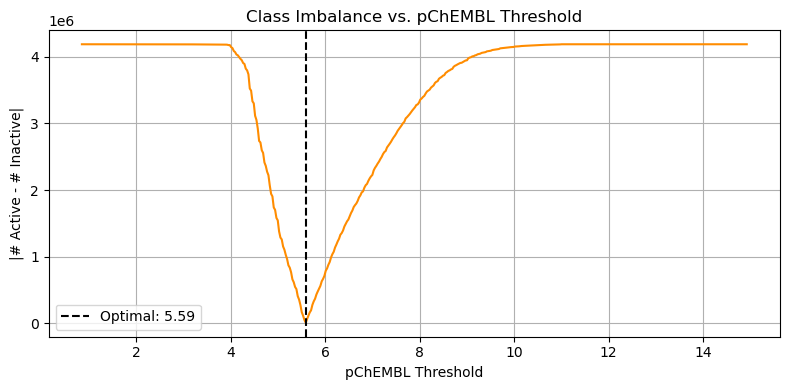

/var/folders/y0/rzqb79d51rl7nd2k33qy2tww0000gn/T/ipykernel_7345/1032137083.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_pchembl["active_5"], discrete=True, shrink=0.7, palette='Reds')
/var/folders/y0/rzqb79d51rl7nd2k33qy2tww0000gn/T/ipykernel_7345/1032137083.py:45: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_pchembl["active_5_59"], discrete=True, shrink=0.7, palette='Blues')


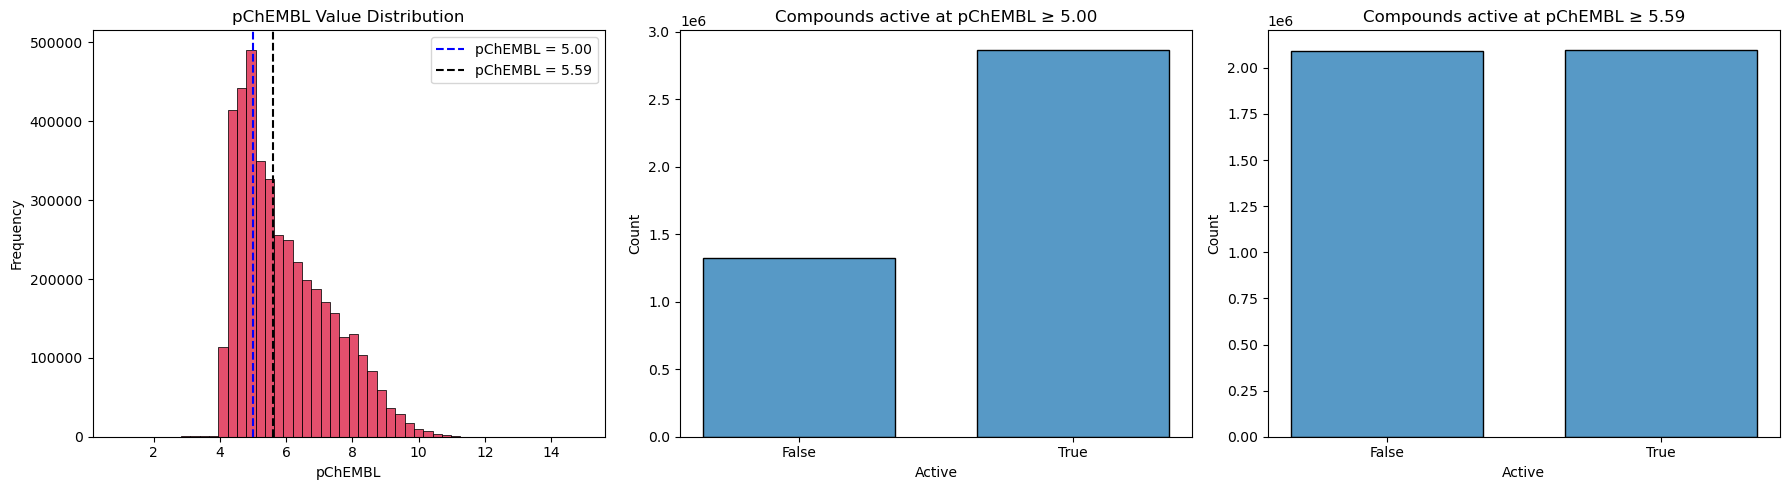

In [5]:
sql_pchembl = """
SELECT pchembl_value
FROM activities
WHERE pchembl_value IS NOT NULL
"""
df_pchembl = chembl_downloader.query(sql_pchembl)
df_pchembl["active_5"] = df_pchembl["pchembl_value"] >= 5.00
df_pchembl["active_5_59"] = df_pchembl["pchembl_value"] >= 5.59

# Identify the threshold where class balance is most equal
pchembl_vals = df_pchembl["pchembl_value"].dropna().sort_values().values
thresholds = np.linspace(pchembl_vals.min(), pchembl_vals.max(), 500)
differences = [abs((pchembl_vals >= t).sum() - (pchembl_vals < t).sum()) for t in thresholds]
optimal_threshold = thresholds[np.argmin(differences)]

# Class imbalance vs. threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, differences, color='darkorange')
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')
plt.title("Class Imbalance vs. pChEMBL Threshold")
plt.xlabel("pChEMBL Threshold")
plt.ylabel("|# Active - # Inactive|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograms
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(df_pchembl["pchembl_value"], bins=50, color="crimson")
plt.axvline(5.00, color='blue', linestyle='--', label='pChEMBL = 5.00')
plt.axvline(5.59, color='black', linestyle='--', label='pChEMBL = 5.59')
plt.title("pChEMBL Value Distribution")
plt.xlabel("pChEMBL")
plt.ylabel("Frequency")
plt.legend()
plt.subplot(1, 3, 2)
sns.histplot(df_pchembl["active_5"], discrete=True, shrink=0.7, palette='Reds')
plt.xticks([0, 1], ['False', 'True'])  # Clean x-axis labels
plt.title("Compounds active at pChEMBL ≥ 5.00")
plt.xlabel("Active")
plt.ylabel("Count")
plt.subplot(1, 3, 3)
sns.histplot(df_pchembl["active_5_59"], discrete=True, shrink=0.7, palette='Blues')
plt.xticks([0, 1], ['False', 'True'])  # Clean x-axis labels
plt.title("Compounds active at pChEMBL ≥ 5.59")
plt.xlabel("Active")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

---

### Scoring the genes

#### Creating a normalised Small Molecule Score (SMS)

This section queries the ChEMBL database to retrieve **the number of modulators per target where pChEMBL ≥ 5**. Since biologics, i.e. antibodies and peptides, typically lack quantitative pChEMBL values (e.g. antibodies, peptides), this metric implicitly becomes a small-molecule druggability indicator. The goal is to prioritise targets that have many potent small-molecule binders. The hard-coded pChEMBL threshold of 5 could be adapted in future versions to reflect dynamical **target class-specific potency expectations**.

After collecting the modulator counts for all eligible ChEMBL targets, the **global maximum** is used as a fixed benchmark, so the gene with the most potent modulators receives **SMS = 1.0**, and all other genes are scaled accordingly. Thus, SMS consistently reflects how modulated a gene is by small molecules, relative to **all human ChEMBL targets**, not just those within the current study list. This makes the score both **biologically interpretable** and **comparable across studies**. Genes without small-molecule modulators get **SMS = 0**.

The retrieved data is then merged with the existing dataset to associate **modulator counts** with genes.

The SQL query<sup>[2]</sup> fetches ChEMBL target IDs (`target_chembl_id`) and counts the number of unique modulators (`molregno`) with pChEMBL ≥ 5. The `ASSAYS` table links activity data (`ACTIVITIES`) with targets (`TARGET_DICTIONARY`). The resulting `modulator_df` is merged with `merged_df` based on ChEMBL Target IDs. Any missing values (`NaN`) in `modulator_count` are replaced with 0. The modulator count is then **normalised** by dividing each value by the **global maximum modulator count**. This approach helps prioritise genes with the highest number of potent small-molecule modulators, ensuring that scoring reflects absolute druggability, rather than just relative ranking within the dataset. Genes lacking pChEMBL-qualified modulators are assigned SMS = 0, indicating a lack of known small-molecule engagement.

##### This code leverages the [`chembl_downloader`](https://github.com/cthoyt/chembl-downloader)  package, developed by @cthoyt.

<sup>[2]: Refer to [`schema_documentation.html`](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/schema_documentation.html) for a more detailed explanation of the ChEMBL 35 schema.</sup>

/var/folders/y0/rzqb79d51rl7nd2k33qy2tww0000gn/T/ipykernel_7345/2535526927.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_molecules.groupby(["max_phase_labelled", "availability_group"]).size().unstack(fill_value=0)


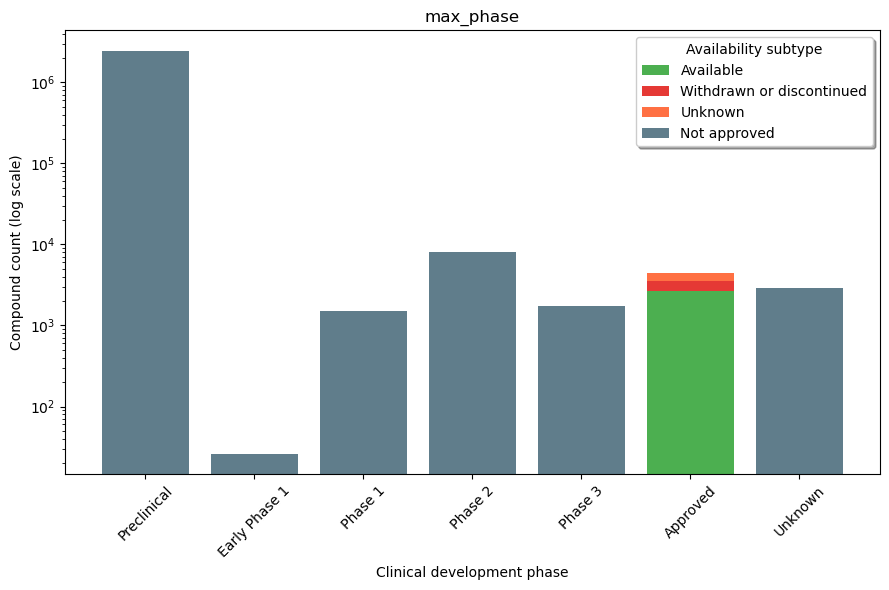

In [34]:
# This relates to scoring further down SMS

sql_molecules = """
SELECT 
    max_phase,
    therapeutic_flag,
    molecule_type,
    first_in_class,
    availability_type,
    withdrawn_flag,
    chemical_probe,
    orphan
FROM molecule_dictionary
"""
df_molecules = chembl_downloader.query(sql_molecules)
df_molecules["max_phase_labelled"] = df_molecules["max_phase"].map({
    -1: "Unknown",
    0.5: "Early Phase 1",
    1: "Phase 1",
    2: "Phase 2",
    3: "Phase 3",
    4: "Approved"
})
df_molecules["max_phase_labelled"] = df_molecules["max_phase_labelled"].fillna("Preclinical")
ordered_phases = ["Preclinical", "Early Phase 1", "Phase 1", "Phase 2", "Phase 3", "Approved", "Unknown"]
df_molecules["max_phase_labelled"] = pd.Categorical(df_molecules["max_phase_labelled"], categories=ordered_phases, ordered=True)

def availability_group(row):
    if row["max_phase_labelled"] != "Approved":
        return "Not approved"
    if row["availability_type"] in [-2, 0]:
        return "Withdrawn or discontinued"
    elif row["availability_type"] in [1, 2]:
        return "Available"
    else:
        return "Unknown"

df_molecules["availability_group"] = df_molecules.apply(availability_group, axis=1)
grouped = df_molecules.groupby(["max_phase_labelled", "availability_group"]).size().unstack(fill_value=0)

# Collapse non-approved phases under "Not approved"
for phase in grouped.index:
    if phase != "Approved":
        total = grouped.loc[phase].sum()
        grouped.loc[phase] = 0
        grouped.loc[phase, "Not approved"] = total

# Column order using your exact labels
ordered_cols = [
    "Available",
    "Withdrawn or discontinued",
    "Unknown",
    "Not approved"
]
grouped = grouped[[col for col in ordered_cols if col in grouped.columns]]

# Colors using your labels
colors = {
    "Available": "#4CAF50",                         # Green
    "Withdrawn or discontinued": "#E53935",         # Red
    "Unknown": "#FF7043",                           # Orange
    "Not approved": "#607D8B"                       # Blue-grey
}
fig, ax = plt.subplots(figsize=(9, 6))
bottom = None
for category in grouped.columns:
    ax.bar(
        grouped.index,
        grouped[category],
        bottom=bottom,
        label=category,
        color=colors.get(category, "gray")
    )
    bottom = grouped[category] if bottom is None else bottom + grouped[category]
ax.set_yscale("log")
ax.set_title("max_phase")
ax.set_xlabel("Clinical development phase")
ax.set_ylabel("Compound count (log scale)")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Availability subtype", shadow=True)
plt.tight_layout()
plt.show()

In [4]:
# Query ChEMBL for the number of modulators per target with pChEMBL ≥ 5
sql = """
SELECT
    TARGET_DICTIONARY.chembl_id AS ChEMBLTargetID,
    COUNT(DISTINCT ACTIVITIES.molregno) AS SmallMoleculeCount
FROM ACTIVITIES
JOIN ASSAYS ON ACTIVITIES.assay_id = ASSAYS.assay_id
JOIN TARGET_DICTIONARY ON ASSAYS.tid = TARGET_DICTIONARY.tid
WHERE ACTIVITIES.pchembl_value >= 5
  AND TARGET_DICTIONARY.organism = 'Homo sapiens'
GROUP BY TARGET_DICTIONARY.chembl_id
"""
smallmoleculecount_df = chembl_downloader.query(sql)
global_max = smallmoleculecount_df["SmallMoleculeCount"].max()
print("Global max small-molecule count:", global_max)

merged_df = merged_df.merge(smallmoleculecount_df, on="ChEMBLTargetID", how="left")
merged_df["SmallMoleculeCount"] = merged_df["SmallMoleculeCount"].fillna(0)
merged_df["SmallMoleculeScore"] = merged_df["SmallMoleculeCount"] / global_max
merged_df

Global max small-molecule count: 24184


,Gene,ChEMBLTargetID,UniProt,GeneFullName,PathwayIDs,PathwayNames,ProteinClass,ScoreGDA,geneNcbiID,geneNcbiType,SmallMoleculeCount,SmallMoleculeScore
0,VPS35,CHEMBL2216744,Q96QK1,VPS35 retromer complex component,R-HSA-162582,Signal Transduction,Transporter,1.0,55737,protein-coding,0.0,0.000000
1,LRRK2,CHEMBL1075104,"Q17RV3,Q5S007",leucine rich repeat kinase 2,R-HSA-162582,Signal Transduction,Kinase,1.0,120892,protein-coding,2227.0,0.092086
2,PARK7,CHEMBL5169188,"Q99497,V9HWC2",Parkinsonism associated deglycase,"R-HSA-392499,R-HSA-9612973","Metabolism of proteins,Autophagy",Enzyme,1.0,11315,protein-coding,19.0,0.000786
3,NR4A2,CHEMBL5002,"Q53EL4,P43354,F1D8N6",nuclear receptor subfamily 4 group A member 2,"R-HSA-392499,R-HSA-74160","Metabolism of proteins,Gene expression (Transc...",Nuclear receptor,1.0,4929,protein-coding,84.0,0.003473
4,BDNF,CHEMBL4523205,"A0A0E3SU01,P23560",brain derived neurotrophic factor,"R-HSA-162582,R-HSA-1643685,R-HSA-74160","Signal Transduction,Disease,Gene expression (T...",Signaling,1.0,627,protein-coding,3.0,0.000124
5,MAPT,CHEMBL1293224,"B3KTM0,P10636",microtubule associated protein tau,"R-HSA-112316,R-HSA-168256,R-HSA-5357801","Neuronal System,Immune System,Programmed Cell ...",,1.0,4137,protein-coding,24184.0,1.000000
6,MAOB,CHEMBL2039,"B7Z242,P27338",monoamine oxidase B,R-HSA-1430728,Metabolism,,1.0,4129,protein-coding,3307.0,0.136743
7,PINK1,CHEMBL3337330,Q9BXM7,PTEN induced kinase 1,"R-HSA-74160,R-HSA-9612973","Gene expression (Transcription),Autophagy",Kinase,1.0,65018,protein-coding,3.0,0.000124
8,SNCA,CHEMBL6152,"P37840,H6UYS5",synuclein alpha,"R-HSA-168256,R-HSA-392499","Immune System,Metabolism of proteins",Transporter,1.0,6622,protein-coding,340.0,0.014059
9,GBA1,CHEMBL2179,"B7Z6S9,P04062,A0A068F658",glucosylceramidase beta 1,"R-HSA-1430728,R-HSA-392499","Metabolism,Metabolism of proteins",,1.0,2629,protein-coding,615.0,0.025430


In [7]:
sql = '''
SELECT md.pref_name, md.chembl_id, cs.accession, act.pchembl_value
FROM activities act
JOIN assays a ON act.assay_id = a.assay_id
JOIN target_dictionary td ON a.tid = td.tid
JOIN target_components tc ON td.tid = tc.tid
JOIN component_sequences cs ON tc.component_id = cs.component_id
JOIN drug_mechanism dm ON td.chembl_id = dm.tid
JOIN molecule_dictionary md ON dm.molregno = md.molregno
WHERE md.molecule_type = 'Protein'
  AND act.pchembl_value IS NOT NULL
LIMIT 20;
'''
df = chembl_downloader.query(sql)
df

,pref_name,chembl_id,accession,pchembl_value


#### Biologic Drug Score (BDS)

This section queries the ChEMBL database to compute a **Biologic Drug Score (BDS)** for each target. While the Small Molecule Score (SMS) relies on **activity data**, which is available only for small-molecule compounds, many **biologic drugs (e.g. antibodies, oligonucleotides, proteins)** do **not** have pChEMBL values and would otherwise be missed in targetability assessments.

To address this gap, BDS evaluates therapeutic relevance based on biologic drugs linked to each target and their **clinical approval status**. The scoring scheme is based on the highest clinical phase of biologic drugs targeting a given protein:

| Criteria                                     | Score |
| -------------------------------------------- | ----- |
| Phase 4 drug, not withdrawn                  | 1.0   |
| Phase 2 or 3 drug, not withdrawn             | 0.7   |
| Phase 1 drug                                 | 0.3   |
| Withdrawn, preclinical, or no biologic drugs | 0.0   |

The resulting `biologics_df` contains one row per target with a `BiologicDrugScore` between `0.0` and `1.0`.

In [ ]:
sql= """
SELECT
    TARGET_DICTIONARY.chembl_id AS ChEMBLTargetID,
    MAX(
        CASE
            WHEN MOLECULE_DICTIONARY.max_phase = 4 AND MOLECULE_DICTIONARY.withdrawn_flag = 0 THEN 1.0
            WHEN MOLECULE_DICTIONARY.max_phase IN (2,3) AND MOLECULE_DICTIONARY.withdrawn_flag = 0 THEN 0.7
            WHEN MOLECULE_DICTIONARY.max_phase = 1 THEN 0.3
            ELSE 0.0
        END
    ) AS BiologicDrugScore
FROM DRUG_MECHANISM
JOIN MOLECULE_DICTIONARY ON DRUG_MECHANISM.molregno = MOLECULE_DICTIONARY.molregno
JOIN TARGET_DICTIONARY ON DRUG_MECHANISM.tid = TARGET_DICTIONARY.tid
WHERE MOLECULE_DICTIONARY.molecule_type NOT IN ('Small molecule', 'Unknown')
  AND TARGET_DICTIONARY.target_type = 'SINGLE PROTEIN'
GROUP BY TARGET_DICTIONARY.chembl_id
"""

biologics_df = chembl_downloader.query(sql)
biologics_df

### Creating a normalised Structure Score (SS)

To further prioritise gene targets based on structural tractability, this section introduces a **Structure Score (SS)** that reflects the availability and quality of experimentally determined 3D structures for each gene's protein product(s). The score is derived from the [EBI Proteins API](https://www.ebi.ac.uk/proteins/api/doc/) using UniProt accessions linked to each target.

UniProt entries are queried individually (or in batches if multiple IDs are present), and the available **PDB** structures are assessed based on resolution and experimental method.

| Structure Availability                                    | Score |
| --------------------------------------------------------- | ----- |
| At least three crystal structures with resolution < 2.5 Å | `1.0` |
| At least one crystal structure with resolution < 2.5 Å    | `0.8` |
| Only NMR or lower-quality structures (≥ 2.5 Å)            | `0.5` |
| No structural data available                              | `0.0` |

This approach allows us to boost the prioritisation of gene targets that are **experimentally well-characterised**, and therefore more amenable to rational drug design and docking studies.

Letting:

* $G$ be the number of high-resolution crystal structures available (resolution < 2.5 Å)
* $M$ be the number of moderate-resolution or NMR/EM structures
* The **Structure Score** is computed as:

$$
SS = 
\begin{cases}
1.0 & \text{if } G \geq 3 \\
0.8 & \text{if } 1 \leq G < 3 \\
0.5 & \text{if } G = 0 \text{ and } M \geq 1 \\
0.0 & \text{otherwise}
\end{cases}
$$

This ensures that **targets with multiple high-quality structural entries receive the highest score**, while moderately resolved or NMR-only structures still receive partial credit.

In [ ]:
def get_structure_score(uniprot_ids):
    if pd.isna(uniprot_ids):
        return 0.0
    uniprot_list = [uid.strip() for uid in uniprot_ids.split(',')]
    num_good, num_moderate = 0, 0
    for uniprot_id in uniprot_list:
        url = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
        try:
            r = requests.get(url, headers={"Accept": "application/json"}, timeout=10)
            if not r.ok:
                continue
            data = r.json()
            pdb_entries = [ref for ref in data.get("dbReferences", []) if ref.get("type") == "PDB"]
            if not pdb_entries:
                continue
            for pdb in pdb_entries:
                props = pdb.get("properties", {})
                method = props.get("method", "").lower()
                resolution_str = props.get("resolution", None)
                try:
                    resolution = float(resolution_str.split()[0]) if resolution_str else None
                except:
                    resolution = None
                if resolution and resolution < 2.5:
                    num_good += 1
                elif resolution or "nmr" in method or "em" in method:
                    num_moderate += 1
        except:
            continue
    if num_good >= 3:
        return 1.0
    elif num_good >= 1:
        return 0.8
    elif num_moderate >= 1:
        return 0.5
    else:
        return 0.0

tqdm.pandas()
merged_df["StructureScore"] = merged_df["UniProt"].progress_apply(get_structure_score)
merged_df

This section calculates the **Targetability Score** ----

$$
  \int_0^\infty \frac{x^3}{e^x-1}\,dx = \frac{\pi^4}{15}
$$

In [ ]:
merged_df["ScoreGDA"] = pd.to_numeric(merged_df["ScoreGDA"], errors="coerce")
merged_df["ModulatorScore"] = pd.to_numeric(merged_df["ModulatorScore"], errors="coerce")
merged_df["TargetabilityScore"] = merged_df["ScoreGDA"] * (1.0 + merged_df["ModulatorScore"])
merged_df = merged_df.sort_values(by="TargetabilityScore", ascending=False)
merged_df.to_csv("TS.csv", sep=',', index=False)
merged_df

In [ ]:
# Define API parameters
base_url = "https://api.disgenet.com/api/v1/gda/summary"
headers = {
    "accept": "application/csv",
    "Authorization": "59699c2e-c741-4eb2-b31b-57d446a785f9"
}
order_by = "score"
max_pages = 6  # DisGeNET API allows a maximum of 100 pages, so adjust accordingly

top_genes = merged_df.sort_values(by="TargetabilityScore", ascending=False)["Gene"].head(10).tolist()  # Get the top genes from `merged_df`
genes = ",".join(top_genes)
df_list = []
for page in range(max_pages):
    print(f"Fetching page {page + 1}/{max_pages}")
    url = f"{base_url}?gene_symbol={genes}&order_by={order_by}&page_number={page}"  # Construct request URL with pagination
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        response_text = response.text
        try:
            df_page = pd.read_csv(StringIO(response_text), sep=",")
        except pd.errors.ParserError:
            print(f"CSV failed on page {page}, trying tab-separated format...")
            df_page = pd.read_csv(StringIO(response_text), sep="\t")
        df_list.append(df_page)
    else:
        print(f"Failed to fetch page {page}. Status code: {response.status_code}")
        break

# Merge all retrieved pages
ranked_df = pd.concat(df_list, ignore_index=True)
if ranked_df.columns[-1].startswith("EI"):
   ranked_df = ranked_df.iloc[:, :-1]  # Drop the last column if malformed

# Drop unnecessary columns
columns_to_drop = [
    "EI", "EL", "assocID", "chemsIncludedInEvidenceBySource", "diseaseClasses_DO", "diseaseClasses_HPO", "diseaseClasses_UMLS_ST", "diseaseVocabularies", "geneDPI",
    "geneDSI", "geneEnsemblIDs", "geneProteinClassIDs", "geneProteinStrIDs", "genepLI", "numCTsupportingAssociation", "numChemsIncludedInEvidences", 
    "numPMIDSWithChemsIncludedInEvidences", "numPMIDs", "numberChemsFiltered", "numberPmidsWithChemsFiltered", "yearFinal", "yearInitial"
]
ranked_df = ranked_df.drop(columns=columns_to_drop, errors='ignore')

if "symbolOfGene" in ranked_df.columns and "score" in ranked_df.columns:
    top_genes_order = {gene: rank for rank, gene in enumerate(top_genes) if gene in ranked_df["symbolOfGene"].unique()}
    # Assign gene rank based on the predefined order
    ranked_df["gene_rank"] = ranked_df["symbolOfGene"].map(top_genes_order)
    # Sort by gene rank (preserving the predetermined order) and then by score (descending)
    ranked_df = ranked_df.sort_values(by=["gene_rank", "score"], ascending=[True, False]).drop(columns=["gene_rank"])

ranked_df.to_csv("DisGDis.csv", index=False)
ranked_df

-----

### MeSH mapping and hierarchical processing

This section of the pipeline maps **UMLS CUIs** to their corresponding **MeSH UIDs** and retrieves **hierarchical relationships** from the MeSH ontology to support score normalisation across related diseases.

The process begins by adding two new columns to the `ranked_df`:
- `"MSH"`: stores the mapped **MeSH UID**.
- `"MSH_normalised_name"`: contains the corresponding standardised **MeSH disease name**.

For each disease (row) in `ranked_df`, the CUI is used to fetch:
- A MeSH UID via `fetch_mesh_from_cui(cui)`.
- A normalised name via `fetch_mesh_name(mesh_id)`.

These mappings ensure consistency in disease terminology and allow downstream use of the structured MeSH hierarchy.

Diseases without valid MeSH mappings are removed to maintain data integrity. The full mapping of CUI to MeSH IDs and disease names is then saved to `hierarchies/MeSH_mapping.csv`.

For the **top 10 ranked genes**, the script creates individual input files located in `hierarchies/input_files/`. Each file contains:
- The **MeSH-normalised disease name**.
- The **MeSH UID**.
- The **GDA score** (`score`) from DisGeNET.

To avoid redundancy, only the highest-scoring entry is kept per MeSH term. This ensures that each disease is represented uniquely and meaningfully for the gene.

Each input file is then processed to:
- **Fetch MeSH parent terms** for each disease via the UMLS API (`/parents` endpoint).
- **Construct tree-like structures**, where diseases are connected to their ancestors in the MeSH ontology.
- **Filter out diseases that are themselves parents**, focusing the analysis on leaf or intermediate terms.

The script recursively builds **hierarchical trees** for each non-parent disease using the `build_tree` function, storing:
- The disease’s level in the hierarchy.
- The original GDA score.
- All ancestral relationships.

These trees are then merged to represent the full hierarchical context of each disease-gene association.

Finally, for each gene, a `.txt` file is saved in `hierarchies/output_files/` that contains:
- A visual, indented tree of diseases and their parents.
- Scores annotated at each level.
- An **average GDA score** computed over all nodes in the tree, offering a smoothed, hierarchy-aware representation of disease burden per gene.

![MAPT Alzheimer Hierarchy](hierarchies/hierarchy_example.png)

##### Why use MeSH hierarchy-based aggregation in drug repositioning?

The MeSH hierarchy groups diseases into structured, parent–child relationships. In drug repositioning:
- A drug might not target a disease directly, but its parent condition (e.g. Alzheimer disease → Dementia).
- Aggregating scores along the MeSH tree allows one to:
    - Smooth noisy associations.
    - Capture indirect links between genes and broader disease categories.
    - Identify targetable diseases within the same pathological cluster.

This is especially useful in polypharmacology, where one drug may act on multiple targets involved in related conditions.

In [ ]:
# Loads cache if re-ran
cache_file = "hierarchies/MeSH_cache.csv"
try:
    mesh_cache = pd.read_csv(cache_file).set_index("CUI").to_dict("index")
except FileNotFoundError:
    mesh_cache = {}

ranked_df["MSH"] = None
ranked_df["MSH_normalised_name"] = None
for index, row in tqdm(ranked_df.iterrows(), total=len(ranked_df), desc="Fetching MeSH Data"):
    cui = row["diseaseUMLSCUI"]
    if pd.notna(cui):
        if cui in mesh_cache:
            ranked_df.at[index, "MSH"] = mesh_cache[cui]["MSH"]
            ranked_df.at[index, "MSH_normalised_name"] = mesh_cache[cui]["MSH_normalised_name"]
        else:
            try:
                mesh_id = fetch_mesh_from_cui(cui)
                mesh_name = fetch_mesh_name(mesh_id) if mesh_id else None
                ranked_df.at[index, "MSH"] = mesh_id
                ranked_df.at[index, "MSH_normalised_name"] = mesh_name
                mesh_cache[cui] = {"MSH": mesh_id, "MSH_normalised_name": mesh_name}
            except Exception as e:
                print(f"Error fetching MeSH for {cui}: {e}")
            time.sleep(0.5)  # Sleep between API calls

# Save updated cache
pd.DataFrame.from_dict(mesh_cache, orient="index").reset_index().rename(columns={"index": "CUI"}).to_csv(cache_file, index=False)

ranked_df = ranked_df.dropna(subset=["MSH"])
ranked_df.to_csv("hierarchies/MeSH_mapping.csv", index=False)

# Save gene-wise input files
for i, gene in enumerate(top_genes, start=1):
    input_file = f"hierarchies/input_files/{gene}_{i}_input.csv"
    df_input = ranked_df[ranked_df["symbolOfGene"] == gene][["MSH_normalised_name", "MSH", "score"]]
    df_input = df_input.sort_values(by="score", ascending=False).drop_duplicates(subset=["MSH"], keep="first")
    df_input.to_csv(input_file, index=False)
    print(f"Processed {gene}, saved to {input_file}")

In [ ]:
input_folder = "hierarchies/input_files/"
output_folder = "hierarchies/output_files/"
input_files = glob.glob(f"{input_folder}*_input.csv")
failed_mesh_ids = []
cache_file = "hierarchies/parents_cache.json"
if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        parents_cache = json.load(f)
else:
    parents_cache = {}

# If "Error fetching parents" appears for a MeSH ID, it typically means the root of the hierarchy has been reached
for file_path in tqdm(input_files, desc="Processing input files"):
    gene = file_path.split("/")[-1].split("_input.csv")[0]
    output_file = f"{output_folder}{gene}_output.txt"
    if os.path.exists(output_file):
        print(f"Skipping {gene}, output already exists.")
        continue  # Skip reprocessing if output file exists
    df = pd.read_csv(file_path, dtype=str)
    df["score"] = df["score"].astype(float)
    score_dict = dict(zip(df["MSH"], df["score"]))
    mesh_name_dict = dict(zip(df["MSH"], df["MSH_normalised_name"]))
    hierarchy = defaultdict(lambda: {"name": None, "parents": [], "score": None})

    def fetch_parents(mesh_id):
        if not mesh_id or mesh_id.startswith("U") or mesh_id.startswith("V-MSH"):
            return []
        if mesh_id in parents_cache:
            return parents_cache[mesh_id]
        try:
            time.sleep(API_DELAY)
            url = f"{BASE_URL}source/MSH/{mesh_id}/parents?apiKey={API_KEY}"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                results = [(item["ui"], item["name"]) for item in data.get("result", [])]
                parents_cache[mesh_id] = results
                return results
        except Exception as e:
            print(f"Error fetching parents for {mesh_id}: {e}")
        parents_cache[mesh_id] = []
        return []

    all_parents = set()
    for mesh_id in df["MSH"]:
        parents = fetch_parents(mesh_id)
        for p_id, _ in parents:
            all_parents.add(p_id)

    def build_tree(mesh_id, lineage=None, level=0):
        if lineage is None:
            lineage = []
        if mesh_id in lineage:
            return []
        disease_name = fetch_mesh_name(mesh_id, name_dict=mesh_name_dict)
        if not disease_name:
            return []
        score = score_dict.get(mesh_id, "NaN")
        parents = fetch_parents(mesh_id)
        hierarchy[mesh_id]["name"] = disease_name
        hierarchy[mesh_id]["parents"] = parents
        hierarchy[mesh_id]["score"] = score
        if not parents:
            return [[(level, score, disease_name, mesh_id)]]
        trees = []
        for parent_id, parent_name in parents:
            subtree = build_tree(parent_id, lineage + [mesh_id], level + 1)
            trees.append([(level, score, disease_name, mesh_id)] + [item for sublist in subtree for item in sublist])
        return trees

    disease_trees = {}
    for mesh_id in df["MSH"]:
        if mesh_id in all_parents:
            continue
        trees = build_tree(mesh_id)
        disease_trees[mesh_id] = disease_trees.get(mesh_id, []) + trees

    merged_trees = {}
    for mesh_id, trees in disease_trees.items():
        merged_tree = {}
        for tree in trees:
            for level, score, name, mesh in tree:
                if mesh not in merged_tree:
                    merged_tree[mesh] = {"level": level, "score": score, "name": name, "children": []}
                parent = next((node for node in tree if node[3] != mesh), None)
                if parent:
                    parent_id = parent[3]
                    if parent_id not in merged_tree:
                        merged_tree[parent_id] = {"level": parent[0], "score": parent[1], "name": parent[2], "children": []}
                    merged_tree[parent_id]["children"].append(mesh)
        merged_trees[mesh_id] = merged_tree

    with open(output_file, "w") as f:
        for mesh_id, tree in merged_trees.items():
            total_score = 0
            count = 0
            f.write(f"\nMerged hierarchy for {mesh_name_dict.get(mesh_id, mesh_id)} ({mesh_id})\n\n")
            for node_id, node_data in tree.items():
                indent = "\t" * node_data["level"]
                score_str = f"({node_data['score']:.2f})" if isinstance(node_data["score"], float) else "(NaN)"
                f.write(f"{score_str}{indent}-{node_data['name']}; {node_id}\n")
                if isinstance(node_data["score"], float):
                    total_score += node_data["score"]
                    count += 1
            avg_score = total_score / count if count > 0 else "NaN"
            f.write(f"\n{mesh_id} AVERAGE = {avg_score:.2f}\n")
    print(f"{gene} tree saved to {output_file}")

    with open(cache_file, "w") as f:
        json.dump(parents_cache, f)
    print(f"Cached parents saved to: {cache_file}")

In [ ]:
from glob import glob

input_folder = "hierarchies/output_files/"
output_folder = "hierarchies/summary_csvs/"
os.makedirs(output_folder, exist_ok=True)

merged_pattern = re.compile(
    r"Merged hierarchy for (.+?) \((D\d+|C\d+)\).*?(?:\n.*?)*?\n\2 AVERAGE = ([\d.]+)",
    re.DOTALL
)

for file_path in glob(f"{input_folder}/*_output.txt"):
    gene_name = os.path.basename(file_path).replace("_output.txt", "")
    output_rows = []
    with open(file_path, "r") as file:
        content = file.read()
        matches = merged_pattern.findall(content)
        for disease_name, mesh_id, avg_score in matches:
            output_rows.append({
                "Disease": disease_name.strip(),
                "MeSH_ID": mesh_id,
                "Average_Score": float(avg_score)
            })
    df = pd.DataFrame(output_rows)
    if not df.empty:
        df["Rank"] = df["Average_Score"].rank(method="min", ascending=False)
        df = df.sort_values(by="Rank")
    output_csv = os.path.join(output_folder, f"{gene_name}_averaged_scores.csv")
    df.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv}")

In [ ]:
merged_df = pd.read_csv("TS.csv", dtype=str)
merged_df["TargetabilityScore"] = pd.to_numeric(merged_df["TargetabilityScore"], errors="coerce")
summary_folder = "hierarchies/summary_csvs/"
disease_files = glob(f"{summary_folder}/*_averaged_scores.csv")

# Create a mapping from gene → top 3 disease names and IDs
top_disease_info = {}
for file_path in disease_files:
    gene = os.path.basename(file_path).split("_")[0]
    df_disease = pd.read_csv(file_path)
    df_disease = df_disease[df_disease["MeSH_ID"] != selected_mesh_id]  # Exclude the queried disease
    if not df_disease.empty:
        df_top3 = df_disease.sort_values(by="Average_Score", ascending=False).head(3)
        disease_names = df_top3["Disease"].tolist()
        mesh_ids = df_top3["MeSH_ID"].tolist()
        avg_scores = df_top3["Average_Score"].tolist()
        top_disease_info[gene] = {
            "Top_Disease_1_Name": disease_names[0] if len(disease_names) > 0 else None,
            "Top_Disease_2_Name": disease_names[1] if len(disease_names) > 1 else None,
            "Top_Disease_3_Name": disease_names[2] if len(disease_names) > 2 else None,
            "Top_Disease_1_ID": mesh_ids[0] if len(mesh_ids) > 0 else None,
            "Top_Disease_2_ID": mesh_ids[1] if len(mesh_ids) > 1 else None,
            "Top_Disease_3_ID": mesh_ids[2] if len(mesh_ids) > 2 else None,
            "Top_Disease_1_Score": avg_scores[0] if len(avg_scores) > 0 else None,
            "Top_Disease_2_Score": avg_scores[1] if len(avg_scores) > 1 else None,
            "Top_Disease_3_Score": avg_scores[2] if len(avg_scores) > 2 else None,
        }

# Map these top diseases to merged_df based on gene symbol
for col in ["Top_Disease_1_Name", "Top_Disease_2_Name", "Top_Disease_3_Name",
            "Top_Disease_1_ID", "Top_Disease_2_ID", "Top_Disease_3_ID",
            "Top_Disease_1_Score", "Top_Disease_2_Score", "Top_Disease_3_Score"]:
    merged_df[col] = merged_df["Gene"].map(lambda g: top_disease_info.get(g, {}).get(col))
merged_df.to_csv("TS_with_top_diseases.csv", index=False)
print("TS_with_top_diseases.csv created with top 3 diseases per gene.")

In [ ]:
# Example list of top 3 diseases per gene (MeSH IDs)
top_diseases = [
    "D000544",  # Alzheimer Disease
    "D003704",  # Dementia
    "D019636",  # Neurodegenerative Diseases
]

# Construct CTD API URL
base_url = "https://ctdbase.org/tools/batchQuery.go"
params = {
    "inputType": "disease",
    "inputTerms": "|".join(top_diseases),
    "report": "chems_curated",
    "format": "tsv"
}

# Send GET request
response = requests.get(base_url, params=params)

# Save and parse the TSV data
if response.status_code == 200:
    with open("ctd_disease_drug_results.tsv", "w") as f:
        f.write(response.text)
    df = pd.read_csv("ctd_disease_drug_results.tsv", sep="\t")
    print(df.head())  # Preview
    # Optional: Filter to include only therapeutic drugs
    df = df[df["DirectEvidence"].str.contains("therapeutic", na=False)]
    # Save cleaned result
    df.to_csv("ctd_disease_drug_filtered.csv", index=False)
    print("CTD drug associations saved.")
else:
    print("Failed to fetch data:", response.status_code)
